In [1]:
%pylab inline
%config InlineBackend.figure_format = 'svg'
import pylab as plb
plb.rcParams['pdf.fonttype'] = 42
recalc_meds = False #recalculate the groupwise median stats set to False to load from file

Populating the interactive namespace from numpy and matplotlib


In [2]:
def parse_GMR_genotype(genotype):
    """get the GMR and UAS keys in a given genotype"""
    print genotype
    gcamp_idx =  genotype.find('GCaMP6f')
    GFP_idx = genotype.find('GFP')
    gmr_idx = genotype.find('GMR')
    gmr_str = genotype[gmr_idx+3:gmr_idx+8]
    if gcamp_idx > 0:
        return {'uas':'GCaMP6f','gal4':gmr_str}
    elif GFP_idx > 0:
        return {'uas':'eGFP','gal4':gmr_str}

#extract the data give the fly_path and 'line_name'
def get_model(fly):
    import muscle_model as mm
    import numpy as np
    import h5py
    import cv2
    model_type = 'volumetric'
    #model_type = 'masks'
    #load the reference frame of the cofocal data and that of the imaged fly
    confocal_model = mm.GeometricModel(filepath = gd.muscle_anatomy_dir + 'confocal_outline_model.cpkl')
    confocal_view = mm.ModelViewMPL(confocal_model)
    pkname = fly.fly_path + '/basis_fits.cpkl'
    fly_frame = mm.Frame();fly_frame.load(pkname)
    #get the transformation matrix A and compose with a scaling using a scaling of s
    #to construct a transformation for homogenious vectors
    s = 1 #scale
    A = fly_frame.get_transform(confocal_model.frame)
    Ap = np.dot([[s,0.0,0],[0,s,0],[0,0,1]],A)
    #parse the GMR genotype to get the line name
    line_name = parse_GMR_genotype(fly.get_genotype())['gal4']
    #get the list of muscles for a given line
    muscles = get_muscle_list(line_name)
    muscles = [m for m in muscles if not('DVM' in m) and not('DLM' in m) and not('ps' in m)]
    #get a reference to the image data
    fly_record = h5py.File(fly.fly_path + 'fly_record.hdf5','r')
    exp_record = fly_record['experiments'].values()[0]
    imgs = exp_record['tiff_data']['images']
    #the output shape of the warped model
    output_shape = np.shape(imgs[0])
    if model_type == 'masks':
        #get the mask of all the muscles for fit
        masks = confocal_model.get_masks(fly_frame,np.shape(imgs[0]))
        #create the model using only the muscles that express in a given line
        model = np.vstack([masks[mask_key].T.ravel().astype(float) for mask_key in muscles])
        #construct a mask do reduce the projection to just the data within the model
        fit_pix_mask = np.sum(model,axis=0) > 0
    if model_type == 'volumetric':
        model_data = h5py.File(gd.muscle_anatomy_dir + 'flatened_model.hdf5','r')
        model_muscles = [np.array(model_data[muscle]) for muscle in muscles]
        output_shapes = [output_shape for muscle in muscles]
        transforms = [Ap[:-1,:] for muscle in muscles]
        model = map(cv2.warpAffine,model_muscles,transforms,output_shapes)
        model = np.vstack([muscle.T.ravel() for muscle in model])
        #model = np.vstack([cv2.warpAffine(np.array(model_data[muscle]), \
        #                               Ap[:-1,:],output_shape).T.ravel() \
        #                for muscle in muscles])
        fit_pix_mask = np.ones_like(model[0]) > 0

    return muscles,model

def get_line_database():
    #print line_name
    import cPickle
    f = open('../mn_expression_matrix_plot/line_database.cpkl','rb')
    line_database = cPickle.load(f)
    f.close()
    return line_database

def get_muscle_list(line_name):
    line_database = get_line_database()
    muscle_names = list()
    for key in line_database[line_name].keys():
        if line_database[line_name][key] > 0:
            muscle_names.append(key)
    muscle_names = sorted(muscle_names)
    #muscle_names = sorted(get_muscle_list(line_name))
    return muscle_names

In [3]:
import group_data as gd

In [4]:
netfly = gd.GMR22H05_pr_swarm.flies[-5]

In [5]:
muscles,model = get_model(netfly)

+;P{20XUAS-IVS-GCaMP6f}attP40/+;P{y[+t7.7] w[+mC]=GMR22H05-GAL4}attP2/+


In [6]:
muscles

['b1',
 'b2',
 'b3',
 'hg1',
 'hg2',
 'hg3',
 'hg4',
 'i1',
 'i2',
 'iii1',
 'iii24',
 'iii3',
 'nm',
 'pr',
 'tpd',
 'tpv',
 'ttm']

In [7]:
muscles = muscles[:-3]
model = model[:-3]

In [8]:
import sympy
import numpy as np
from sympy.interactive import printing
printing.init_printing(use_latex='mathjax')
M = sympy.Matrix(['A','B','C','D','F'])
m_gram = M*M.T
m_gram

⎡ 2                     ⎤
⎢A    A⋅B  A⋅C  A⋅D  A⋅F⎥
⎢                       ⎥
⎢      2                ⎥
⎢A⋅B  B    B⋅C  B⋅D  B⋅F⎥
⎢                       ⎥
⎢           2           ⎥
⎢A⋅C  B⋅C  C    C⋅D  C⋅F⎥
⎢                       ⎥
⎢                2      ⎥
⎢A⋅D  B⋅D  C⋅D  D    D⋅F⎥
⎢                       ⎥
⎢                     2 ⎥
⎣A⋅F  B⋅F  C⋅F  D⋅F  F  ⎦

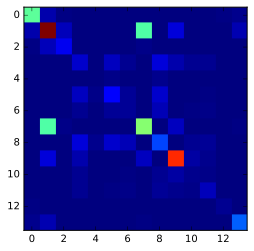

In [9]:
#remove tp's and ttm from model
model_gram = np.dot(model,model.T)
imshow(model_gram,interpolation = 'nearest')

In [10]:
norms = sympy.Matrix(np.diag(m_gram)).applyfunc(sympy.sqrt)
norms

⎡   ____⎤
⎢  ╱  2 ⎥
⎢╲╱  A  ⎥
⎢       ⎥
⎢   ____⎥
⎢  ╱  2 ⎥
⎢╲╱  B  ⎥
⎢       ⎥
⎢   ____⎥
⎢  ╱  2 ⎥
⎢╲╱  C  ⎥
⎢       ⎥
⎢   ____⎥
⎢  ╱  2 ⎥
⎢╲╱  D  ⎥
⎢       ⎥
⎢   ____⎥
⎢  ╱  2 ⎥
⎣╲╱  F  ⎦

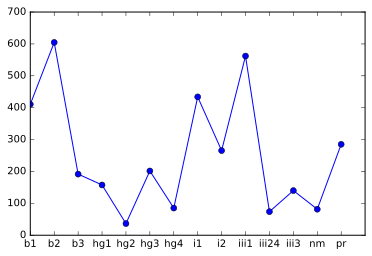

In [11]:
model_norms = np.sqrt(np.diag(model_gram))
plot(model_norms,'-o')
xticks(range(len(muscles)),muscles);

In [12]:
norm_mtrx = sympy.Matrix(norms.T*norms)
inv = lambda x:1/x
inv_norms = norm_mtrx.applyfunc(inv)
inv_norms

⎡          1           ⎤
⎢──────────────────────⎥
⎢ 2    2    2    2    2⎥
⎣A  + B  + C  + D  + F ⎦

In [13]:
model_norm_mtrx = np.dot(model_norms[:,newaxis],model_norms[:,newaxis].T)
model_inv_norms = 1/model_norm_mtrx

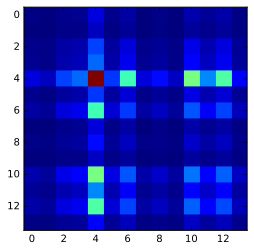

In [14]:
imshow(model_inv_norms,interpolation = 'nearest')

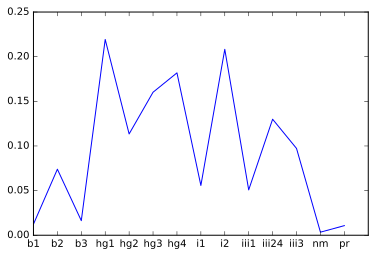

In [16]:
model_eqn =  np.diag(dot(model_inv_norms,model_gram))-1
plot(model_eqn/len(muscles))
xticks(range(len(muscles)),muscles);

In [17]:
import h5py
model_data = h5py.File(gd.muscle_anatomy_dir + 'flatened_model.hdf5','r')
model_muscles = [np.array(model_data[muscle]) for muscle in muscles]

In [18]:
def parse_GMR_genotype(genotype):
    """get the GMR and UAS keys in a given genotype"""
    print genotype
    gcamp_idx =  genotype.find('GCaMP6f')
    GFP_idx = genotype.find('GFP')
    gmr_idx = genotype.find('GMR')
    gmr_str = genotype[gmr_idx+3:gmr_idx+8]
    if gcamp_idx > 0:
        return {'uas':'GCaMP6f','gal4':gmr_str}
    elif GFP_idx > 0:
        return {'uas':'eGFP','gal4':gmr_str}

def get_line_database():
    #print line_name
    import cPickle
    f = open('../mn_expression_matrix_plot/line_database.cpkl','rb')
    line_database = cPickle.load(f)
    f.close()
    return line_database

def get_muscle_list(line_name):
    line_database = get_line_database()
    muscle_names = list()
    #print line_database.keys()
    for key in line_database[line_name].keys():
        if line_database[line_name][key] > 0:
            muscle_names.append(key)
    muscle_names = sorted(muscle_names)
    #muscle_names = sorted(get_muscle_list(line_name))
    return muscle_names

def get_model(line_name):
    import numpy as np
    import h5py
    import group_data as gd
    from scipy.misc import imresize
    muscles = get_muscle_list(line_name)
    muscles = [m for m in muscles if not('DVM' in m) 
                                   and not('DLM' in m) 
                                   and not('ps' in m)
                                   and not('ttm' in m)
                                   and not('tpd' in m)
                                   and not('tpv' in m)]
    model_data = h5py.File(gd.muscle_anatomy_dir + 'flatened_model.hdf5','r')
    model = [np.array(model_data[muscle]) for muscle in muscles]
    model = [imresize(muscle,0.1) for muscle in model]
    model = np.vstack([muscle.T.ravel() for muscle in model])
    return muscles,model

def calc_filter_independence(model):
    import numpy as np
    model_gram = np.dot(model,model.T)
    model_norms = np.sqrt(np.diag(model_gram))
    model_norm_mtrx = np.dot(model_norms[:,newaxis],model_norms[:,newaxis].T)
    model_inv_norms = 1/model_norm_mtrx
    dim = shape(model)[0]
    print dim
    ind_indexes = ((np.diag(dot(model_gram,model_inv_norms))-1))/dim
    cos_similarity = model_gram*model_inv_norms
    return ind_indexes,cos_similarity

14


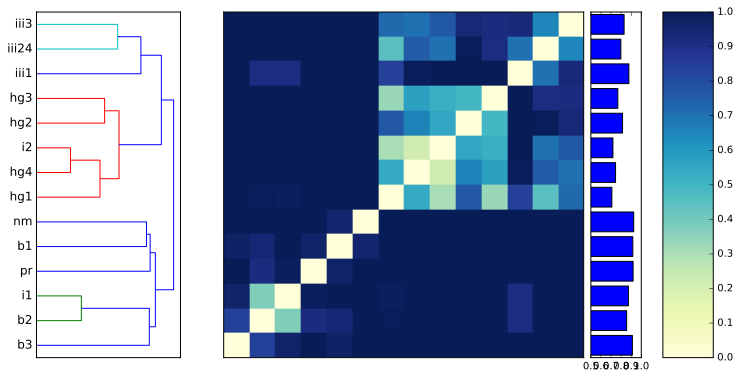

In [19]:
import scipy
import pylab
import scipy.cluster.hierarchy as sch
method = 'weighted' 
muscles,model = get_model('22H05')
ind_indexes,cos_similarity = calc_filter_independence(model.astype(float))
cos_similarity[cos_similarity > 1] = 1
#D = np.arccos(cos_similarity)
D = 1-cos_similarity
# Compute and plot first dendrogram.

fig = pylab.figure(figsize=(10,8))
ax1 = fig.add_axes([0.09,0.1,0.2,0.6])
Y = sch.linkage(D, method=method)
Z1 = sch.dendrogram(Y, orientation='right',labels = muscles)
ax1.set_xticks([])
#ax1.set_yticks([])
 
# Plot distance matrix.
axmatrix = fig.add_axes([0.35,0.1,0.50,0.6])
idx1 = Z1['leaves']
idx2 = Z1['leaves']
D = D[idx1,:]
D = D[:,idx1]
im = axmatrix.matshow(D, aspect='auto', origin='lower', cmap=pylab.cm.YlGnBu)
axmatrix.set_xticks([])
axmatrix.set_yticks([])

# Plot sum cos distance
axbars = fig.add_axes([0.86,0.1,0.07,0.6],sharey = axmatrix)
barh(np.arange(shape(D)[0]),(np.sum(D,axis = 0)-np.diag(D))/14.0,align='center')
gca().set_xbound(0.5,1)

# Plot colorbar.
axcolor = fig.add_axes([0.96,0.1,0.07,0.6])
#barh(np.arange(shape(D)[0]),np.sum(D,axis = 0)/17.0,align='center')


#gca().set_ybound(,17)

pylab.colorbar(im, cax=axcolor)
#fig.show()
fig.savefig('22H05_filter_cluster.pdf')

11


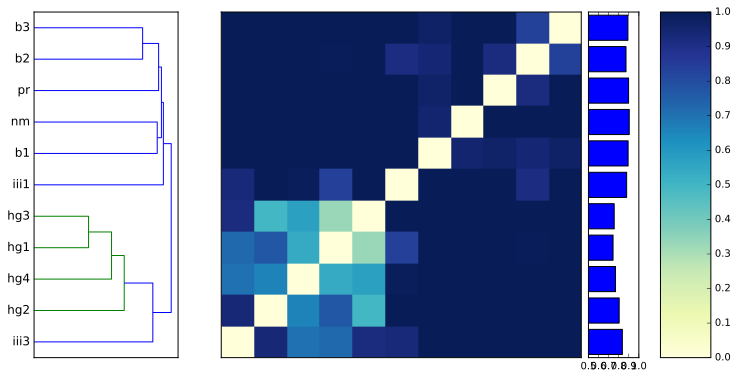

In [20]:
import scipy
import pylab
import scipy.cluster.hierarchy as sch
method = 'weighted' 
muscles,model = get_model('39E01')
ind_indexes,cos_similarity = calc_filter_independence(model.astype(float))
cos_similarity[cos_similarity > 1] = 1
#D = np.arccos(cos_similarity)
D = 1-cos_similarity
# Compute and plot first dendrogram.

fig = pylab.figure(figsize=(10,8))
ax1 = fig.add_axes([0.09,0.1,0.2,0.6])
Y = sch.linkage(D, method=method)
Z1 = sch.dendrogram(Y, orientation='right',labels = muscles)
ax1.set_xticks([])
#ax1.set_yticks([])
 
# Plot distance matrix.
axmatrix = fig.add_axes([0.35,0.1,0.50,0.6])
idx1 = Z1['leaves']
idx2 = Z1['leaves']
D = D[idx1,:]
D = D[:,idx1]
im = axmatrix.matshow(D, aspect='auto', origin='lower', cmap=pylab.cm.YlGnBu)
axmatrix.set_xticks([])
axmatrix.set_yticks([])

# Plot sum cos distance
axbars = fig.add_axes([0.86,0.1,0.07,0.6],sharey = axmatrix)
barh(np.arange(shape(D)[0]),(np.sum(D,axis = 0)-np.diag(D))/11.0,align='center')
gca().set_xbound(0.5,1.0)

# Plot colorbar.
axcolor = fig.add_axes([0.96,0.1,0.07,0.6])
#barh(np.arange(shape(D)[0]),np.sum(D,axis = 0)/17.0,align='center')


#gca().set_ybound(,17)

pylab.colorbar(im, cax=axcolor)
#fig.show()
fig.savefig('39E01_filter_cluster.pdf')